# Trade Execution - Predicting Shortfall

## Introduction
Within finance, an optimal trade execution strategy can enhance a portfolio’s performance by
by using short-term expectations of stock price movements to optimally time a trade.
However, it is difficult to capture all of the idiosyncratic causes of stock price changes in the short term. Alpha profiling, which uses the past behavior of portfolio managers
(PMs) to learn patterns about optimal trade executions (The Trade, 2014), seeks to indirectly
capture the idiosyncratic market beliefs using the PMs historical trading strategy.

A webpage version will be available at
https://github.com/silkeherold/probprog-finalproject/final-project/....

In [124]:
%matplotlib inline
import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import scipy.stats as sps

from edward.models import Bernoulli,MultivariateNormalTriL, Normal
from edward.util import rbf

In [ ]:
ed.set_seed(42)

## Data

The dataset is comprised of the following colums:

* Implementation Shortfall (bps) R
* Expected Cost (bps) R+
* Trade Amount ($), negative indicates sells R
* Forecast Participation Rate (%) R+
* Stock Volatility R+
 * 5 day, 10 day
* Momentum R
 * Open, 5 Day, 10 Day
    
The goal is to predict the deviation between implementation shortfall (actual cost) and expected costs. These deviations are largely influenced by underlying price changes in the market. The model is split into two components: direction and magnitude.

<b>Magnitude</b>

This is a regression problem, which will indicate how large of an absolute deviation will occur. Moves in underlying prices are largely dependent on the trade size, security volatility, and absolute momentum strength. They are also influenced by external idiosynractic events, which are not covered here.

<b>Direction</b>

This is a classification problem that will determine whether the deviation will be positive or not. A positive deviation indicates that the execution cost is more expensive than predicted. These deviations are mostly driven by short-term price moves. The direction of short-term price moves is modeled using the momentum components, which indicate the extent that a price has been increasing or in recent history. 

Number of data points: 911
Number of magnitude features: 7
Number of direction features: 3


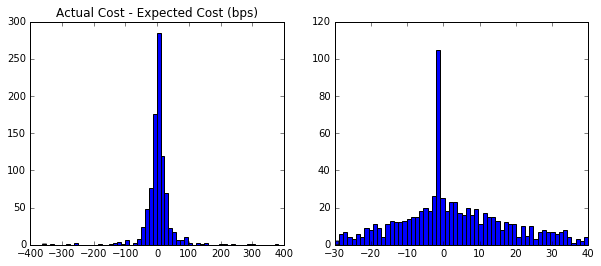

In [104]:
data = np.loadtxt('data/train_data.csv', delimiter=',',skiprows=1)

# Data Size
N = data.shape[0]  # number of data points
D_size = data.shape[1]-2  # number of features
D_dir = data.shape[1]-2-4  # number of features
print("Number of data points: {}".format(N))
print("Number of magnitude features: {}".format(D_size))
print("Number of direction features: {}".format(D_dir))

# Cost Deviation
y_train = data[:, 0]-data[:,1]  # IS - EC

# Histograms of y variable
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Actual Cost - Expected Cost (bps)')
_=plt.hist(y_train,bins=60)
plt.subplot(1,2,2)
_=plt.hist(y_train,bins=60,range=(-30, 40))

# Magnitude Training Data
X_train_size = np.absolute(data[:, 2:])
y_train_size = np.absolute(data[:, 0]-data[:,1])

# Direction Training Data
X_train_dir = data[:, 6:]
y_train_dir = data[:, 0]-data[:,1]
y_train_dir[y_train_dir[:] > 0] = 1  # Convert to Classification
y_train_dir[y_train_dir[:] < 0] = 0  # Convert to Classification

## 1. Magnitude
### Model - GP Regression

The GaussianProcessRegressor implements Gaussian processes (GP) for regression purposes. For this, the prior of the GP needs to be specified. The prior mean is assumed to be constant and zero (for normalize_y=False) or the training data’s mean (for normalize_y=True). The prior’s covariance is specified by a passing a kernel object. The hyperparameters of the kernel are optimized during fitting of GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) based on the passed optimizer. As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer. The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, None can be passed as optimizer. Source: http://scikit-learn.org/stable/modules/gaussian_process.html

http://katbailey.github.io/post/gaussian-processes-for-dummies/

https://arxiv.org/pdf/1502.02843.pdf

http://www.gaussianprocess.org/gpml/chapters/RW.pdf
Definition 2.1 A Gaussian process is a collection of random variables, any Gaussian process
finite number of which have a joint Gaussian distribution.
A Gaussian process is completely specified by its mean function and co- covariance and
variance function. We define mean function m(x) and the covariance function mean function
k(x, x0) of a real process f(x) as 
m(x) = E[f(x)]
k(x, x0) = E[(f(x) − m(x))(f(x') − m(x'))] 
and will write the Gaussian process as
f(x) ∼ GP(m(x), k(x, x')

Usually, for notational simplicity we will take the mean function to be zero,
although this need not be done, see section 2.7.


A Gaussian process is a powerful object for modeling nonlinear
relationships between pairs of random variables. It defines a distribution over
(possibly nonlinear) functions, which can be applied for representing
our uncertainty around the true functional relationship.
Here we define a Gaussian process model for classification
(Rasumussen & Williams, 2006).

Formally, a distribution over functions $f:\mathbb{R}^D\to\mathbb{R}$ can be specified
by a Gaussian process
$$
\begin{align*}
  p(f)
  &=
  \mathcal{GP}(f\mid \mathbf{0}, k(\mathbf{x}, \mathbf{x}^\prime)),
\end{align*}
$$
whose mean function is the zero function, and whose covariance
function is some kernel which describes dependence between
any set of inputs to the function.

Given a set of input-output pairs
$\{\mathbf{x}_n\in\mathbb{R}^D,y_n\in\mathbb{R}\}$,
the likelihood can be written as a multivariate normal

\begin{align*}
  p(\mathbf{y})
  &=
  \text{Normal}(\mathbf{y} \mid \mathbf{0}, \mathbf{K})
\end{align*}

where $\mathbf{K}$ is a covariance matrix given by evaluating
$k(\mathbf{x}_n, \mathbf{x}_m)$ for each pair of inputs in the data
set.

The above applies directly for regression where $\mathbb{y}$ is a
real-valued response, but not for (binary) classification, where $\mathbb{y}$
is a label in $\{0,1\}$. To deal with classification, we interpret the
response as latent variables which is squashed into $[0,1]$. We then
draw from a Bernoulli to determine the label, with probability given
by the squashed value.

Define the likelihood of an observation $(\mathbf{x}_n, y_n)$ as

\begin{align*}
  p(y_n \mid \mathbf{z}, x_n)
  &=
  \text{Bernoulli}(y_n \mid \text{logit}^{-1}(\mathbf{x}_n^\top \mathbf{z})).
\end{align*}

Define the prior to be a multivariate normal

\begin{align*}
  p(\mathbf{z})
  &=
  \text{Normal}(\mathbf{z} \mid \mathbf{0}, \mathbf{K}),
\end{align*}

with covariance matrix given as previously stated.

Let's build the model in Edward. We use a radial basis function (RBF)
kernel, also known as the squared exponential or exponentiated
quadratic. It returns the kernel matrix evaluated over all pairs of
data points; we then Cholesky decompose the matrix to parameterize the
multivariate normal distribution.

In [100]:
X = tf.placeholder(tf.float32, [N, 3])
z =ed.rbf(X,None,10.0,1.0)+0.00001*np.eye(N) # Add small amount to remove small negative eigenvalues
#z = tf.cholesky(ed.rbf(X,None,10.0,1.0)+0.000001*np.eye(N)) # Add small amount to remove small negative eigenvalues
#y = Bernoulli(logits=f)
f = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X,None,10.0,1.0)+0.000001*np.eye(N)))
y = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X,None,10.0,1.0)+0.000001*np.eye(N)))

In [101]:
sess = tf.Session()
z=sess.run(z,feed_dict={X: X_train_dir})
sess.close()

#print(X_train)

In [102]:
e=np.linalg.eigvals(z)
print(e[e<0])

[]


Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

### Inference

Perform variational inference.
Define the variational model to be a fully factorized normal.

In [10]:
#qf = Normal(loc=tf.Variable(tf.random_normal([N])),
#            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

Run variational inference for `500` iterations.

In [11]:
#inference = ed.KLqp({f: qf}, data={X: X_train, y: y_train})
#inference.run(n_iter=5000)

5000/5000 [100%] ██████████████████████████████ Elapsed: 4851s | Loss: nan


In this case
`KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](/tutorials/klqp).
(This example happens to be slow because evaluating and inverting full
covariances in Gaussian processes happens to be slow.)

## 2. Direction
### Model - GP Classification




In [119]:
X_dir = tf.placeholder(tf.float32, [N, D_dir])
f_dir = MultivariateNormalTriL(loc=tf.zeros(N), scale_tril=tf.cholesky(rbf(X_dir)+0.00001*np.eye(N)))
y_dir = Bernoulli(logits=f_dir)

### Inference

In [120]:
qf_dir = Normal(loc=tf.Variable(tf.random_normal([N])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N]))))

In [121]:
inference_dir = ed.KLqp({f_dir: qf_dir}, data={X_dir: X_train_dir, y_dir: y_train_dir})
inference_dir.initialize(n_iter=5000)

{'t': 1, 'loss': 1.0711274e+08}
{'t': 1001, 'loss': 80231.609}
{'t': 2001, 'loss': 32911.141}
{'t': 3001, 'loss': 22509.631}
{'t': 4001, 'loss': 23596.1}


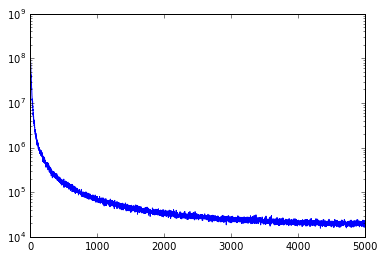

In [123]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
curve = []
for _ in range(inference_dir.n_iter):
    status = inference_dir.update()
    if _%1000 == 0:
        print(status)
    curve.append(status['loss'])
_=plt.semilogy(curve)
